# Project: 멋진 챗봇 만들기

In [4]:
!pip install gensim
!pip install nltk
!pin install pandas numpy

/bin/bash: line 1: pin: command not found


In [5]:
import numpy
import pandas
import torch
import nltk
import gensim

print(numpy.__version__)
print(pandas.__version__)
print(torch.__version__)
print(nltk.__version__)
print(gensim.__version__)

1.26.4
2.2.2
2.8.0+cu126
3.9.1
4.3.3


## Step 1. 데이터 로드

In [6]:
import pandas as pd

# CSV 파일 읽기
df = pd.read_csv('ChatbotData.csv')

# 질문과 답변을 각각 변수에 저장
questions = df['Q'].tolist()  # 또는 df['Q'].values
answers = df['A'].tolist()    # 또는 df['A'].values

# 확인해보기
print(f"총 질문 개수: {len(questions)}")
print(f"총 답변 개수: {len(answers)}")
print("\n첫 5개 질문:")
for i in range(5):
    print(f"Q{i+1}: {questions[i]}")
print("\n첫 5개 답변:")
for i in range(5):
    print(f"A{i+1}: {answers[i]}")

총 질문 개수: 11823
총 답변 개수: 11823

첫 5개 질문:
Q1: 12시 땡!
Q2: 1지망 학교 떨어졌어
Q3: 3박4일 놀러가고 싶다
Q4: 3박4일 정도 놀러가고 싶다
Q5: PPL 심하네

첫 5개 답변:
A1: 하루가 또 가네요.
A2: 위로해 드립니다.
A3: 여행은 언제나 좋죠.
A4: 여행은 언제나 좋죠.
A5: 눈살이 찌푸려지죠.


## Step 2. 데이터 정제

In [7]:
import re

def preprocess_sentence(sentence):
    """
    문장 전처리 함수
    1. 영문자를 모두 소문자로 변환
    2. 영문자, 한글, 숫자, 주요 특수문자만 남기고 나머지 제거
    """
    # 1. 소문자로 변환
    sentence = sentence.lower()

    # 2. 영문자, 한글, 숫자, 주요 특수문자만 남기기
    # 한글: ㄱ-ㅎ, ㅏ-ㅣ, 가-힣
    # 영문자: a-z
    # 숫자: 0-9
    # 주요 특수문자: 공백, 마침표, 쉼표, 물음표, 느낌표, 하이픈 등
    sentence = re.sub(r'[^a-z가-힣ㄱ-ㅎㅏ-ㅣ0-9\s.,?!-]', '', sentence)

    # 연속된 공백을 하나로 통합
    sentence = re.sub(r'\s+', ' ', sentence)

    # 문장 앞뒤 공백 제거
    sentence = sentence.strip()

    return sentence

# 테스트
test_sentences = [
    "안녕하세요! How are YOU?",
    "오늘 날씨가 좋네요~~ ^^",
    "Hello123 @#$% 테스트입니다!",
    "   여러   공백    처리   테스트   "
]

print("전처리 결과:")
for sentence in test_sentences:
    processed = preprocess_sentence(sentence)
    print(f"원본: {sentence}")
    print(f"전처리: {processed}")
    print("-" * 50)

전처리 결과:
원본: 안녕하세요! How are YOU?
전처리: 안녕하세요! how are you?
--------------------------------------------------
원본: 오늘 날씨가 좋네요~~ ^^
전처리: 오늘 날씨가 좋네요
--------------------------------------------------
원본: Hello123 @#$% 테스트입니다!
전처리: hello123 테스트입니다!
--------------------------------------------------
원본:    여러   공백    처리   테스트   
전처리: 여러 공백 처리 테스트
--------------------------------------------------


In [8]:
# 앞서 정의한 preprocess_sentence 함수 사용

# 1. questions와 answers 리스트에 전처리 적용
print("전처리 시작...")

# 질문 전처리
processed_questions = []
for question in questions:
    processed_q = preprocess_sentence(question)
    processed_questions.append(processed_q)

# 답변 전처리
processed_answers = []
for answer in answers:
    processed_a = preprocess_sentence(answer)
    processed_answers.append(processed_a)

print("전처리 완료!")

# 2. 전처리 결과 확인
print(f"\n전처리된 질문 개수: {len(processed_questions)}")
print(f"전처리된 답변 개수: {len(processed_answers)}")

print("\n=== 전처리 전후 비교 (첫 5개) ===")
for i in range(min(5, len(questions))):
    print(f"\n[{i+1}번째]")
    print(f"원본 질문: {questions[i]}")
    print(f"전처리 질문: {processed_questions[i]}")
    print(f"원본 답변: {answers[i]}")
    print(f"전처리 답변: {processed_answers[i]}")
    print("-" * 60)

# 3. 빈 문장이나 너무 짧은 문장 확인
empty_questions = [i for i, q in enumerate(processed_questions) if len(q.strip()) == 0]
empty_answers = [i for i, a in enumerate(processed_answers) if len(a.strip()) == 0]

print(f"\n빈 질문 개수: {len(empty_questions)}")
print(f"빈 답변 개수: {len(empty_answers)}")

if empty_questions:
    print(f"빈 질문 인덱스: {empty_questions[:0]}")  # 처음 10개만
if empty_answers:
    print(f"빈 답변 인덱스: {empty_answers[:10]}")    # 처음 10개만

전처리 시작...
전처리 완료!

전처리된 질문 개수: 11823
전처리된 답변 개수: 11823

=== 전처리 전후 비교 (첫 5개) ===

[1번째]
원본 질문: 12시 땡!
전처리 질문: 12시 땡!
원본 답변: 하루가 또 가네요.
전처리 답변: 하루가 또 가네요.
------------------------------------------------------------

[2번째]
원본 질문: 1지망 학교 떨어졌어
전처리 질문: 1지망 학교 떨어졌어
원본 답변: 위로해 드립니다.
전처리 답변: 위로해 드립니다.
------------------------------------------------------------

[3번째]
원본 질문: 3박4일 놀러가고 싶다
전처리 질문: 3박4일 놀러가고 싶다
원본 답변: 여행은 언제나 좋죠.
전처리 답변: 여행은 언제나 좋죠.
------------------------------------------------------------

[4번째]
원본 질문: 3박4일 정도 놀러가고 싶다
전처리 질문: 3박4일 정도 놀러가고 싶다
원본 답변: 여행은 언제나 좋죠.
전처리 답변: 여행은 언제나 좋죠.
------------------------------------------------------------

[5번째]
원본 질문: PPL 심하네
전처리 질문: ppl 심하네
원본 답변: 눈살이 찌푸려지죠.
전처리 답변: 눈살이 찌푸려지죠.
------------------------------------------------------------

빈 질문 개수: 0
빈 답변 개수: 0


### 긴 문장 제외 (20단어 초과 문장 없애기)


=== 질문 길이 분포 ===
총 문장 수: 11823
평균 길이: 3.59
중간값: 3.00
최대 길이: 15
최소 길이: 1
표준편차: 1.62
분위수:
  25%: 2.0
  50%: 3.0
  75%: 4.0
  90%: 6.0
  95%: 7.0
  99%: 8.0

=== 답변 길이 분포 ===
총 문장 수: 11823
평균 길이: 3.69
중간값: 3.00
최대 길이: 21
최소 길이: 1
표준편차: 1.86
분위수:
  25%: 2.0
  50%: 3.0
  75%: 5.0
  90%: 6.0
  95%: 7.0
  99%: 10.0

=== 질문 길이별 빈도 (상위 30개) ===
길이  1:  625개 (  5.3%)
길이  2: 2498개 ( 21.1%)
길이  3: 3342개 ( 28.3%)
길이  4: 2512개 ( 21.2%)
길이  5: 1455개 ( 12.3%)
길이  6:  754개 (  6.4%)
길이  7:  361개 (  3.1%)
길이  8:  163개 (  1.4%)
길이  9:   70개 (  0.6%)
길이 10:   25개 (  0.2%)
길이 11:   10개 (  0.1%)
길이 12:    7개 (  0.1%)
길이 15:    1개 (  0.0%)

=== 답변 길이별 빈도 (상위 30개) ===
길이  1:  739개 (  6.3%)
길이  2: 2472개 ( 20.9%)
길이  3: 3117개 ( 26.4%)
길이  4: 2384개 ( 20.2%)
길이  5: 1436개 ( 12.1%)
길이  6:  814개 (  6.9%)
길이  7:  415개 (  3.5%)
길이  8:  213개 (  1.8%)
길이  9:   92개 (  0.8%)
길이 10:   64개 (  0.5%)
길이 11:   30개 (  0.3%)
길이 12:   23개 (  0.2%)
길이 13:    8개 (  0.1%)
길이 14:    6개 (  0.1%)
길이 15:    4개 (  0.0%)
길이 16:    4개 (  0

/tmp/ipython-input-1957013160.py:74: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1957013160.py:74: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1957013160.py:74: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1957013160.py:74: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1957013160.py:74: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1957013160.py:74: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1957013160.py:74: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp

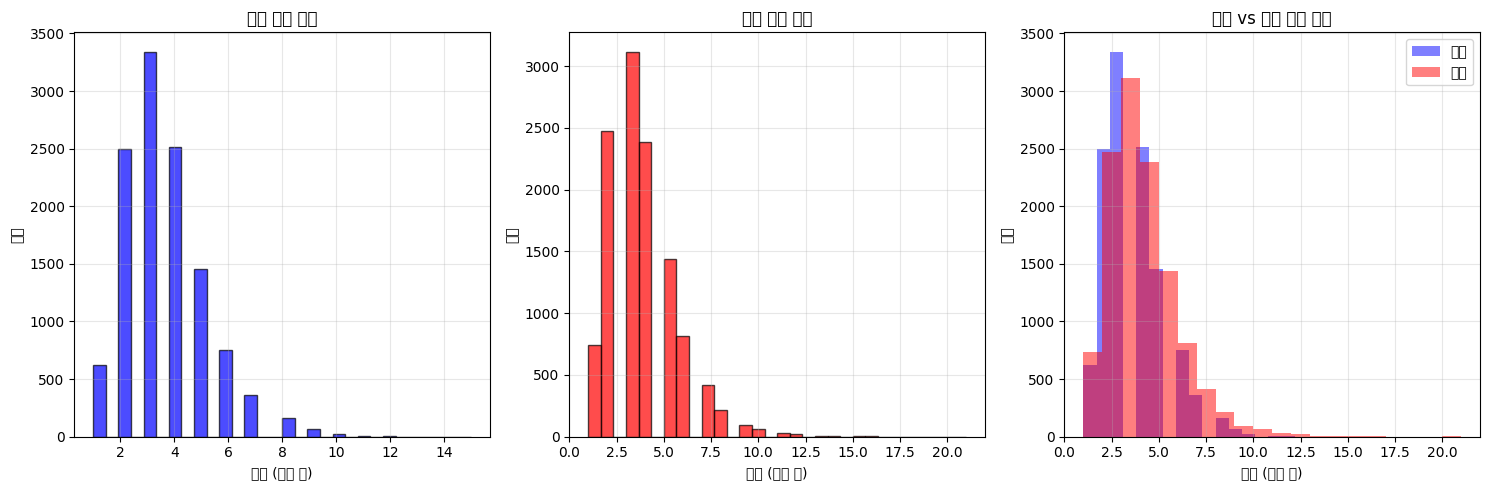


=== 질문 길이 범위별 분포 ===
1-5 단어    : 10432개 ( 88.2%)
6-10 단어   : 1373개 ( 11.6%)
11-15 단어  :   18개 (  0.2%)
16-20 단어  :    0개 (  0.0%)
21-30 단어  :    0개 (  0.0%)
31+ 단어    :    0개 (  0.0%)

=== 답변 길이 범위별 분포 ===
1-5 단어    : 10148개 ( 85.8%)
6-10 단어   : 1598개 ( 13.5%)
11-15 단어  :   71개 (  0.6%)
16-20 단어  :    5개 (  0.0%)
21-30 단어  :    1개 (  0.0%)
31+ 단어    :    0개 (  0.0%)

=== 특이사항 체크 ===
빈 질문: 0개
빈 답변: 0개
20단어 초과 질문: 0개
20단어 초과 답변: 1개


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 기본 길이 분포 계산
def analyze_length_distribution(sentences, name):
    """문장들의 길이 분포를 분석하는 함수"""
    lengths = [len(sentence.split()) for sentence in sentences]  # 공백 기준 단어 수

    print(f"\n=== {name} 길이 분포 ===")
    print(f"총 문장 수: {len(sentences)}")
    print(f"평균 길이: {np.mean(lengths):.2f}")
    print(f"중간값: {np.median(lengths):.2f}")
    print(f"최대 길이: {max(lengths)}")
    print(f"최소 길이: {min(lengths)}")
    print(f"표준편차: {np.std(lengths):.2f}")

    # 분위수 정보
    percentiles = [25, 50, 75, 90, 95, 99]
    print("분위수:")
    for p in percentiles:
        print(f"  {p}%: {np.percentile(lengths, p):.1f}")

    return lengths

# 질문과 답변 길이 분포 분석
question_lengths = analyze_length_distribution(processed_questions, "질문")
answer_lengths = analyze_length_distribution(processed_answers, "답변")

# 2. 길이별 빈도 분포
def show_frequency_distribution(lengths, name, max_show=30):
    """길이별 빈도 분포를 보여주는 함수"""
    print(f"\n=== {name} 길이별 빈도 (상위 {max_show}개) ===")

    from collections import Counter
    length_counts = Counter(lengths)

    for length in sorted(length_counts.keys())[:max_show]:
        count = length_counts[length]
        percentage = (count / len(lengths)) * 100
        print(f"길이 {length:2d}: {count:4d}개 ({percentage:5.1f}%)")

show_frequency_distribution(question_lengths, "질문")
show_frequency_distribution(answer_lengths, "답변")

# 3. 시각화 (matplotlib 사용)
plt.figure(figsize=(15, 5))

# 질문 길이 히스토그램
plt.subplot(1, 3, 1)
plt.hist(question_lengths, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('질문 길이 분포')
plt.xlabel('길이 (단어 수)')
plt.ylabel('빈도')
plt.grid(True, alpha=0.3)

# 답변 길이 히스토그램
plt.subplot(1, 3, 2)
plt.hist(answer_lengths, bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('답변 길이 분포')
plt.xlabel('길이 (단어 수)')
plt.ylabel('빈도')
plt.grid(True, alpha=0.3)

# 질문 vs 답변 길이 비교
plt.subplot(1, 3, 3)
plt.hist(question_lengths, bins=20, alpha=0.5, label='질문', color='blue')
plt.hist(answer_lengths, bins=20, alpha=0.5, label='답변', color='red')
plt.title('질문 vs 답변 길이 비교')
plt.xlabel('길이 (단어 수)')
plt.ylabel('빈도')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. 특정 길이 범위의 문장 개수
def count_by_length_range(lengths, name):
    """길이 범위별 문장 개수를 계산"""
    print(f"\n=== {name} 길이 범위별 분포 ===")
    ranges = [(1, 5), (6, 10), (11, 15), (16, 20), (21, 30), (31, float('inf'))]

    for start, end in ranges:
        if end == float('inf'):
            count = sum(1 for l in lengths if l >= start)
            range_str = f"{start}+ 단어"
        else:
            count = sum(1 for l in lengths if start <= l <= end)
            range_str = f"{start}-{end} 단어"

        percentage = (count / len(lengths)) * 100
        print(f"{range_str:10s}: {count:4d}개 ({percentage:5.1f}%)")

count_by_length_range(question_lengths, "질문")
count_by_length_range(answer_lengths, "답변")

# 5. 빈 문장이나 너무 긴 문장 체크
print(f"\n=== 특이사항 체크 ===")
empty_questions = sum(1 for s in processed_questions if len(s.strip()) == 0)
empty_answers = sum(1 for s in processed_answers if len(s.strip()) == 0)
print(f"빈 질문: {empty_questions}개")
print(f"빈 답변: {empty_answers}개")

long_questions = sum(1 for l in question_lengths if l > 20)
long_answers = sum(1 for l in answer_lengths if l > 20)
print(f"20단어 초과 질문: {long_questions}개")
print(f"20단어 초과 답변: {long_answers}개")

## Step 3. 데이터 토큰화

In [10]:
# !pip install sentencepiece

In [11]:
import sentencepiece as spm
import io

In [12]:
# 수정된 셀 9: SentencePiece 모델을 먼저 생성하고 로드한 후 사용

def train_sentencepiece_model(sentences, model_name='chatbot_sp', vocab_size=5000):
    """SentencePiece 모델 훈련 함수"""
    with open('temp_corpus.txt', 'w', encoding='utf-8') as f:
        for sentence in sentences:
            f.write(sentence + '\n')

    spm.SentencePieceTrainer.train(
        input='temp_corpus.txt',
        model_prefix=model_name,
        vocab_size=vocab_size,
        character_coverage=0.9995,
        model_type='bpe',
        unk_piece='<unk>',
        bos_piece='<start>',
        eos_piece='<end>',
        pad_piece='<pad>'
    )
    return f'{model_name}.model'

# 1. 먼저 SentencePiece 모델 훈련 및 로드
print("SentencePiece 모델 훈련 중...")
all_text = processed_questions + processed_answers
model_path = train_sentencepiece_model(all_text)

# 2. SentencePiece 프로세서 초기화
sp = spm.SentencePieceProcessor()
sp.load(model_path)
print("SentencePiece 모델 로드 완료")

SentencePiece 모델 훈련 중...
SentencePiece 모델 로드 완료


In [13]:
def sp_tokenize(sentence):
    """SentencePiece를 사용한 토큰화 함수"""
    return sp.encode_as_pieces(sentence)

In [14]:
def build_corpus(source_sentences, target_sentences, tokenizer, max_length=20):
    """
    코퍼스를 구축하는 함수

    Args:
        source_sentences: 소스 문장 리스트 (질문)
        target_sentences: 타겟 문장 리스트 (답변)
        tokenizer: 토크나이저 함수 (sentencepiece)
        max_length: 최대 토큰 길이 (이보다 긴 문장 제외)

    Returns:
        tuple: (processed_sources, processed_targets) - 토큰화된 문장들
    """

    processed_sources = []
    processed_targets = []

    # 중복 체크를 위한 set
    seen_sources = set()
    seen_targets = set()

    print(f"원본 데이터 개수: {len(source_sentences)}")

    for i, (source, target) in enumerate(zip(source_sentences, target_sentences)):
        # 1. 전처리
        processed_source = preprocess_sentence(source)
        processed_target = preprocess_sentence(target)

        # 빈 문장 제거
        if not processed_source.strip() or not processed_target.strip():
            continue

        # 2. 토큰화
        source_tokens = tokenizer(processed_source)
        target_tokens = tokenizer(processed_target)

        # 3. 길이 체크 (최대 길이 이상인 문장 제외)
        if len(source_tokens) > max_length or len(target_tokens) > max_length:
            continue

        # 4. 중복 체크 (소스와 타겟을 각각 체크)
        source_str = ' '.join(source_tokens)
        target_str = ' '.join(target_tokens)

        # 소스나 타겟 중 하나라도 중복이면 해당 쌍 전체를 제외
        if source_str in seen_sources or target_str in seen_targets:
            continue

        # 중복이 아니면 추가
        seen_sources.add(source_str)
        seen_targets.add(target_str)
        processed_sources.append(source_tokens)
        processed_targets.append(target_tokens)

    print(f"필터링 후 데이터 개수: {len(processed_sources)}")
    print(f"제거된 데이터 개수: {len(source_sentences) - len(processed_sources)}")

    return processed_sources, processed_targets

# 4. 함수 실행
print("코퍼스 구축 시작...")
que_corpus, ans_corpus = build_corpus(
    source_sentences=processed_questions,  # 또는 questions (전처리된 것 사용)
    target_sentences=processed_answers,    # 또는 answers (전처리된 것 사용)
    tokenizer=sp_tokenize,
    max_length=20  # 최대 토큰 길이 설정
)

# 결과 확인
print(f"\n=== 코퍼스 구축 결과 ===")
print(f"질문 코퍼스 크기: {len(que_corpus)}")
print(f"답변 코퍼스 크기: {len(ans_corpus)}")

print(f"\n=== 첫 5개 예시 ===")
for i in range(min(5, len(que_corpus))):
    print(f"\n[{i+1}]")
    print(f"질문 토큰: {que_corpus[i]}")
    print(f"답변 토큰: {ans_corpus[i]}")
    print(f"질문 복원: {sp.decode_pieces(que_corpus[i])}")
    print(f"답변 복원: {sp.decode_pieces(ans_corpus[i])}")

# 토큰 길이 분포 확인
import numpy as np
que_lengths = [len(tokens) for tokens in que_corpus]
ans_lengths = [len(tokens) for tokens in ans_corpus]

print(f"\n=== 토큰 길이 통계 ===")
print(f"질문 길이 - 평균: {np.mean(que_lengths):.2f}, 최대: {max(que_lengths)}, 최소: {min(que_lengths)}")
print(f"답변 길이 - 평균: {np.mean(ans_lengths):.2f}, 최대: {max(ans_lengths)}, 최소: {min(ans_lengths)}")

코퍼스 구축 시작...
원본 데이터 개수: 11823
필터링 후 데이터 개수: 7717
제거된 데이터 개수: 4106

=== 코퍼스 구축 결과 ===
질문 코퍼스 크기: 7717
답변 코퍼스 크기: 7717

=== 첫 5개 예시 ===

[1]
질문 토큰: ['▁1', '2', '시', '▁땡', '!']
답변 토큰: ['▁하루', '가', '▁또', '▁가', '네요', '.']
질문 복원: 12시 땡!
답변 복원: 하루가 또 가네요.

[2]
질문 토큰: ['▁1', '지', '망', '▁학교', '▁떨어졌어']
답변 토큰: ['▁위로해', '▁드', '립니다', '.']
질문 복원: 1지망 학교 떨어졌어
답변 복원: 위로해 드립니다.

[3]
질문 토큰: ['▁3', '박', '4', '일', '▁놀러가고', '▁싶다']
답변 토큰: ['▁여행', '은', '▁언제나', '▁좋죠', '.']
질문 복원: 3박4일 놀러가고 싶다
답변 복원: 여행은 언제나 좋죠.

[4]
질문 토큰: ['▁', 'p', 'p', 'l', '▁심', '하네']
답변 토큰: ['▁눈', '살', '이', '▁찌', '푸', '려', '지', '죠', '.']
질문 복원: ppl 심하네
답변 복원: 눈살이 찌푸려지죠.

[5]
질문 토큰: ['▁s', 'd', '카', '드', '▁망', '가', '졌어']
답변 토큰: ['▁다시', '▁새로', '▁사는', '▁게', '▁마음', '▁편', '해요', '.']
질문 복원: sd카드 망가졌어
답변 복원: 다시 새로 사는 게 마음 편해요.

=== 토큰 길이 통계 ===
질문 길이 - 평균: 6.20, 최대: 20, 최소: 1
답변 길이 - 평균: 6.67, 최대: 20, 최소: 1


## Step 4. Augmentation

In [15]:
from gensim.models import KeyedVectors

kv = KeyedVectors.load_word2vec_format("ko.vec", binary=False)

In [16]:
import random
from tqdm import tqdm

def lexical_sub(sentence, wv):
    """개선된 lexical substitution 함수"""
    tokens = sentence.split()
    valid_tokens = [tok for tok in tokens if tok in wv]

    if not valid_tokens:
        return sentence

    selected_tok = random.choice(valid_tokens)

    try:
        similar_words = wv.most_similar(selected_tok, topn=5)
        similar_word = random.choice(similar_words)[0]
        new_sentence = " ".join([similar_word if tok == selected_tok else tok for tok in tokens])
        return new_sentence
    except:
        return sentence

def augment_sentences(sentences, wv):
    """문장 리스트를 증강하는 함수"""
    augmented = []
    print("문장 증강 중...")

    for sentence in tqdm(sentences):
        if isinstance(sentence, list):  # 토큰화된 문장인 경우
            sentence_str = ' '.join(sentence)
            aug_sentence_str = lexical_sub(sentence_str, wv)
            aug_sentence = aug_sentence_str.split()
        else:  # 문자열인 경우
            aug_sentence = lexical_sub(sentence, wv)

        augmented.append(aug_sentence)

    return augmented

# 데이터 3배 증강 실행
print("=== 데이터 3배 증강 시작 ===")

# 원본 데이터 (토큰화된 상태라면 문자열로 변환)
if isinstance(que_corpus[0], list):
    que_strings = [' '.join(tokens) for tokens in que_corpus]
    ans_strings = [' '.join(tokens) for tokens in ans_corpus]
else:
    que_strings = que_corpus.copy()
    ans_strings = ans_corpus.copy()

print(f"원본 데이터 크기: {len(que_strings)}")

# 1. 질문 증강
print("\n1단계: 질문 증강")
augmented_questions = augment_sentences(que_strings, kv)

# 2. 답변 증강
print("\n2단계: 답변 증강")
augmented_answers = augment_sentences(ans_strings, kv)

# 3. 3배 확장된 데이터셋 생성
print("\n3단계: 3배 데이터셋 구성")

# 최종 데이터 구성
final_questions = []
final_answers = []

# 원본 데이터
final_questions.extend(que_strings)
final_answers.extend(ans_strings)

# 증강된 질문 + 원본 답변
final_questions.extend(augmented_questions)
final_answers.extend(ans_strings)  # 원본 답변 재사용

# 원본 질문 + 증강된 답변
final_questions.extend(que_strings)  # 원본 질문 재사용
final_answers.extend(augmented_answers)

print(f"\n=== 증강 완료 ===")
print(f"원본 데이터: {len(que_strings)}쌍")
print(f"최종 데이터: {len(final_questions)}쌍")
print(f"증강 비율: {len(final_questions) / len(que_strings):.1f}배")

# 4. 토큰화 (필요한 경우)
print("\n4단계: 토큰화")
if hasattr(sp, 'encode_as_pieces'):  # SentencePiece 토크나이저가 있는 경우
    final_que_corpus = [sp.encode_as_pieces(q) for q in tqdm(final_questions)]
    final_ans_corpus = [sp.encode_as_pieces(a) for a in tqdm(final_answers)]
else:  # 간단한 공백 토큰화
    final_que_corpus = [q.split() for q in final_questions]
    final_ans_corpus = [a.split() for a in final_answers]

# 5. 결과 확인
print(f"\n=== 최종 결과 ===")
print(f"최종 질문 코퍼스: {len(final_que_corpus)}")
print(f"최종 답변 코퍼스: {len(final_ans_corpus)}")

print(f"\n=== 샘플 확인 (첫 3개 세트) ===")
original_size = len(que_strings)

for i in range(3):
    print(f"\n--- {i+1}번째 샘플 ---")
    # 원본
    print(f"[원본] Q: {final_questions[i]}")
    print(f"[원본] A: {final_answers[i]}")

    # 증강된 질문 + 원본 답변
    print(f"[증강Q] Q: {final_questions[original_size + i]}")
    print(f"[원본A] A: {final_answers[original_size + i]}")

    # 원본 질문 + 증강된 답변
    print(f"[원본Q] Q: {final_questions[2*original_size + i]}")
    print(f"[증강A] A: {final_answers[2*original_size + i]}")

# 최종 변수 업데이트
que_corpus = final_que_corpus
ans_corpus = final_ans_corpus

print(f"\nque_corpus와 ans_corpus가 {len(que_corpus)}개로 업데이트되었습니다!")

=== 데이터 3배 증강 시작 ===
원본 데이터 크기: 7717

1단계: 질문 증강
문장 증강 중...


100%|██████████| 7717/7717 [00:16<00:00, 461.12it/s]



2단계: 답변 증강
문장 증강 중...


100%|██████████| 7717/7717 [00:14<00:00, 521.41it/s]



3단계: 3배 데이터셋 구성

=== 증강 완료 ===
원본 데이터: 7717쌍
최종 데이터: 23151쌍
증강 비율: 3.0배

4단계: 토큰화


100%|██████████| 23151/23151 [00:00<00:00, 72002.86it/s]


=== 최종 결과 ===
최종 질문 코퍼스: 23151
최종 답변 코퍼스: 23151

=== 샘플 확인 (첫 3개 세트) ===

--- 1번째 샘플 ---
[원본] Q: ▁1 2 시 ▁땡 !
[원본] A: ▁하루 가 ▁또 ▁가 네요 .
[증강Q] Q: ▁1 2 시가 ▁땡 !
[원본A] A: ▁하루 가 ▁또 ▁가 네요 .
[원본Q] Q: ▁1 2 시 ▁땡 !
[증강A] A: ▁하루 로 ▁또 ▁가 네요 .

--- 2번째 샘플 ---
[원본] Q: ▁1 지 망 ▁학교 ▁떨어졌어
[원본] A: ▁위로해 ▁드 립니다 .
[증강Q] Q: ▁1 지 오트 ▁학교 ▁떨어졌어
[원본A] A: ▁위로해 ▁드 립니다 .
[원본Q] Q: ▁1 지 망 ▁학교 ▁떨어졌어
[증강A] A: ▁위로해 ▁드 립니다 희영

--- 3번째 샘플 ---
[원본] Q: ▁3 박 4 일 ▁놀러가고 ▁싶다
[원본] A: ▁여행 은 ▁언제나 ▁좋죠 .
[증강Q] Q: ▁3 박이 4 일 ▁놀러가고 ▁싶다
[원본A] A: ▁여행 은 ▁언제나 ▁좋죠 .
[원본Q] Q: ▁3 박 4 일 ▁놀러가고 ▁싶다
[증강A] A: ▁여행 은 ▁언제나 ▁좋죠 희영

que_corpus와 ans_corpus가 23151개로 업데이트되었습니다!


## Step 5. 데이터 벡터화

In [17]:
from collections import Counter
import numpy as np

# 1. 타겟 데이터에 <start>와 <end> 토큰 추가
print("=== 타겟 데이터에 특수 토큰 추가 ===")

# ans_corpus에 <start>와 <end> 토큰 추가
ans_corpus_with_tokens = []
for answer in ans_corpus:
    # 각 답변에 시작과 종료 토큰 추가
    answer_with_tokens = ["<start>"] + answer + ["<end>"]
    ans_corpus_with_tokens.append(answer_with_tokens)

print(f"원본 답변 예시: {ans_corpus[0]}")
print(f"토큰 추가 후: {ans_corpus_with_tokens[0]}")
print(f"처리된 답변 데이터 수: {len(ans_corpus_with_tokens)}")

# 2. 전체 데이터에 대한 단어 사전 구축
print("\n=== 전체 단어 사전 구축 ===")

# 모든 토큰을 하나의 리스트로 수집
all_tokens = []

# 질문 데이터의 모든 토큰 추가
for question in que_corpus:
    all_tokens.extend(question)

# 답변 데이터의 모든 토큰 추가 (특수 토큰 포함)
for answer in ans_corpus_with_tokens:
    all_tokens.extend(answer)

# 토큰 빈도 계산
token_counts = Counter(all_tokens)
print(f"전체 토큰 수: {len(all_tokens)}")
print(f"고유 토큰 수: {len(token_counts)}")

# 빈도 기준으로 단어 사전 생성 (빈도 높은 순으로 정렬)
vocab_size = len(token_counts)
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# 특수 토큰들을 먼저 추가
special_tokens = ["<pad>", "<unk>", "<start>", "<end>"]
vocab_to_idx = {}
idx_to_vocab = {}

# 특수 토큰 인덱스 할당
for i, token in enumerate(special_tokens):
    vocab_to_idx[token] = i
    idx_to_vocab[i] = token

# 나머지 토큰들 인덱스 할당
current_idx = len(special_tokens)
for token, count in sorted_tokens:
    if token not in vocab_to_idx:  # 이미 추가된 특수 토큰은 제외
        vocab_to_idx[token] = current_idx
        idx_to_vocab[current_idx] = token
        current_idx += 1

vocab_size = len(vocab_to_idx)
print(f"최종 어휘 크기: {vocab_size}")
print(f"특수 토큰: {special_tokens}")
print(f"가장 빈도 높은 토큰 10개: {[token for token, count in sorted_tokens[:10]]}")

# 3. 벡터화 함수 정의
def tokenize_and_pad(sentences, vocab_to_idx, max_length=None):
    """
    문장들을 인덱스로 변환하고 패딩 적용
    """
    # 최대 길이 계산 (지정하지 않은 경우)
    if max_length is None:
        max_length = max(len(sentence) for sentence in sentences)

    vectorized = []
    for sentence in sentences:
        # 토큰을 인덱스로 변환
        indices = []
        for token in sentence:
            if token in vocab_to_idx:
                indices.append(vocab_to_idx[token])
            else:
                indices.append(vocab_to_idx["<unk>"])  # 없는 단어는 <unk>로

        # 패딩 적용
        if len(indices) < max_length:
            # 부족한 부분은 <pad> 토큰으로 채움
            indices.extend([vocab_to_idx["<pad>"]] * (max_length - len(indices)))
        else:
            # 길이가 초과하면 자름
            indices = indices[:max_length]

        vectorized.append(indices)

    return np.array(vectorized)

# 4. 최대 길이 설정
que_max_length = max(len(sentence) for sentence in que_corpus)
ans_max_length = max(len(sentence) for sentence in ans_corpus_with_tokens)

print(f"\n=== 시퀀스 길이 정보 ===")
print(f"질문 최대 길이: {que_max_length}")
print(f"답변 최대 길이: {ans_max_length}")

# 5. 벡터화 실행
print("\n=== 벡터화 진행 ===")

# 인코더 입력 데이터 (질문)
enc_train = tokenize_and_pad(que_corpus, vocab_to_idx, max_length=que_max_length)

# 디코더 입력 데이터 (답변 - 특수 토큰 포함)
dec_train = tokenize_and_pad(ans_corpus_with_tokens, vocab_to_idx, max_length=ans_max_length)

print(f"enc_train 형태: {enc_train.shape}")
print(f"dec_train 형태: {dec_train.shape}")

# 6. 결과 확인
print("\n=== 벡터화 결과 확인 ===")
for i in range(3):
    print(f"\n[{i+1}번째 예시]")
    print(f"원본 질문: {que_corpus[i]}")
    print(f"벡터화된 질문: {enc_train[i]}")
    print(f"원본 답변: {ans_corpus_with_tokens[i]}")
    print(f"벡터화된 답변: {dec_train[i]}")

    # 벡터를 다시 토큰으로 변환해서 확인
    restored_question = [idx_to_vocab[idx] for idx in enc_train[i] if idx != vocab_to_idx["<pad>"]]
    restored_answer = [idx_to_vocab[idx] for idx in dec_train[i] if idx != vocab_to_idx["<pad>"]]
    print(f"복원된 질문: {restored_question}")
    print(f"복원된 답변: {restored_answer}")

# 7. 데이터 정보 요약
print(f"\n=== 최종 데이터 정보 ===")
print(f"어휘 크기: {vocab_size}")
print(f"훈련 데이터 수: {len(enc_train)}")
print(f"인코더 입력 크기: {enc_train.shape}")
print(f"디코더 입력 크기: {dec_train.shape}")
print(f"질문 최대 길이: {que_max_length}")
print(f"답변 최대 길이: {ans_max_length}")

# vocab_to_idx, idx_to_vocab 딕셔너리도 나중에 사용할 수 있도록 저장
print(f"\nvocab_to_idx와 idx_to_vocab 딕셔너리가 생성되었습니다.")
print(f"이는 나중에 모델 예측 결과를 텍스트로 변환할 때 필요합니다.")

=== 타겟 데이터에 특수 토큰 추가 ===
원본 답변 예시: ['▁하루', '▁가', '▁또', '▁가', '▁', '네요', '▁.']
토큰 추가 후: ['<start>', '▁하루', '▁가', '▁또', '▁가', '▁', '네요', '▁.', '<end>']
처리된 답변 데이터 수: 23151

=== 전체 단어 사전 구축 ===
전체 토큰 수: 395168
고유 토큰 수: 4401
최종 어휘 크기: 4403
특수 토큰: ['<pad>', '<unk>', '<start>', '<end>']
가장 빈도 높은 토큰 10개: ['▁', '<start>', '<end>', '▁.', '▁이', '?', '▁다', '▁거예요', '▁나', '▁지']

=== 시퀀스 길이 정보 ===
질문 최대 길이: 27
답변 최대 길이: 31

=== 벡터화 진행 ===
enc_train 형태: (23151, 27)
dec_train 형태: (23151, 31)

=== 벡터화 결과 확인 ===

[1번째 예시]
원본 질문: ['▁1', '▁2', '▁시', '▁땡', '▁', '!']
벡터화된 질문: [ 285  286   84 2942    4  141    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
원본 답변: ['<start>', '▁하루', '▁가', '▁또', '▁가', '▁', '네요', '▁.', '<end>']
벡터화된 답변: [  2 376  14  88  14   4  64   5   3   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]
복원된 질문: ['▁1', '▁2', '▁시', '▁땡', '▁', '!']
복원된 답변: ['<start>', '▁하루', '▁가', '▁또', '▁가', '▁', '네

## Step 6. 훈련하기

### 6-1. 모델 정의

In [18]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table
print("슝=3")

슝=3


In [19]:
def generate_padding_mask(seq: torch.Tensor) -> torch.Tensor:
    """
    seq: shape [batch_size, seq_len]의 입력 (토큰 ID 텐서)
    반환: shape [batch_size, 1, 1, seq_len]의 패딩 마스크
         (seq == 0)인 위치가 1, 나머지는 0
    """
    # (seq == 0)은 불리언 텐서를 반환 -> float()로 형변환 -> (1.0 or 0.0)
    # 차원 확장: [batch_size, seq_len] → [batch_size, 1, 1, seq_len]
    return (seq == 0).unsqueeze(1).unsqueeze(2).float()


def generate_lookahead_mask(size: int) -> torch.Tensor:
    """
    size: 문장(시퀀스) 길이
    반환: shape [size, size],
         i < j (대각선 위)에 해당하는 위치가 1, 아닌 곳은 0
         (미래 토큰을 가리기 위한 마스크)
    """
    # triu(diagonal=1)은 주대각선 위가 1, 아래가 0인 텐서를 만들어 줌
    return torch.triu(torch.ones(size, size), diagonal=1)


def generate_masks(src: torch.Tensor, tgt: torch.Tensor):
    """
    src, tgt: shape [batch_size, seq_len]
    3가지 마스크를 반환:
      - enc_mask: 인코더 입력용 패딩 마스크
      - dec_enc_mask: 디코더-인코더 어텐션용 패딩 마스크
      - dec_mask: 디코더 자기어텐션용 마스크(룩어헤드 + 패딩)

    각각의 shape:
      - enc_mask, dec_enc_mask: [batch_size, 1, 1, src_seq_len]
      - dec_mask: [batch_size, 1, tgt_seq_len, tgt_seq_len]
    """
    # 1) 인코더 입력용 패딩 마스크
    enc_mask = generate_padding_mask(src)
    # 2) 디코더에서 인코더 값을 볼 때 사용하는 마스크 (src 마스크 재사용)
    dec_enc_mask = generate_padding_mask(src)

    # 3) 디코더 자기어텐션 마스크 (미래 토큰 방지 룩어헤드 + tgt 자체 패딩 마스크)
    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])  # [tgt_seq_len, tgt_seq_len]
    dec_tgt_padding_mask = generate_padding_mask(tgt)           # [batch_size, 1, 1, tgt_seq_len]

    # 룩어헤드 마스크를 (batch 차원과 head 차원을 가상으로) 확장
    dec_lookahead_mask = dec_lookahead_mask.unsqueeze(0).unsqueeze(1)  # [1, 1, seq_len, seq_len]

    # 패딩 + 룩어헤드 마스크 병합
    # 브로드캐스팅에 의해 shape [batch_size, 1, tgt_seq_len, tgt_seq_len]이 됨

    dec_tgt_padding_mask = dec_tgt_padding_mask.to(device)
    dec_lookahead_mask = dec_lookahead_mask.to(device)

    dec_mask = torch.max(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model을 num_heads로 나눈 만큼이 각 head가 담당할 차원 수
        self.depth = d_model // num_heads

        # Query, Key, Value를 구하는 선형 레이어
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # 최종적으로 head들의 출력을 결합해주는 선형 레이어
        self.linear = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Q, K, V:  [batch_size, num_heads, seq_len, depth]
        mask:     [batch_size, 1, seq_len, seq_len] 혹은
                  [batch_size, num_heads, seq_len, seq_len]
                  (어텐션에서 제외할 위치=1, 사용할 위치=0)
        """
        # d_k = depth
        d_k = Q.size(-1)  # K.shape[-1]도 동일
        # Q와 K의 전치 곱: (batch_size, num_heads, seq_len, seq_len)
        QK = torch.matmul(Q, K.transpose(-1, -2))

        # 스케일링
        scaled_qk = QK / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

        # 마스크가 있는 경우 -1e9(매우 작은 수)를 더하여 softmax 후 확률이 0에 가깝도록 처리
        if mask is not None:
            scaled_qk = scaled_qk + (mask * -1e9)

        attentions = F.softmax(scaled_qk, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        out = torch.matmul(attentions, V)         # (batch_size, num_heads, seq_len, depth)

        return out, attentions

    def split_heads(self, x):
        """
        x: [batch_size, seq_len, d_model]
        반환: [batch_size, num_heads, seq_len, depth]
        """
        bsz, seq_len, _ = x.size()
        # d_model -> (num_heads * depth)이므로 view로 재배치
        x = x.view(bsz, seq_len, self.num_heads, self.depth)
        # (batch_size, seq_len, num_heads, depth) -> (batch_size, num_heads, seq_len, depth)
        x = x.permute(0, 2, 1, 3)
        return x

    def combine_heads(self, x):
        """
        x: [batch_size, num_heads, seq_len, depth]
        반환: [batch_size, seq_len, d_model]
        """
        bsz, num_heads, seq_len, depth = x.size()
        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(bsz, seq_len, self.d_model)
        return x

    def forward(self, Q, K, V, mask=None):
        """
        Q, K, V: [batch_size, seq_len, d_model]
        mask:    [batch_size, 1, seq_len, seq_len] 혹은
                 [batch_size, num_heads, seq_len, seq_len]
        """
        # W_q, W_k, W_v는 각각 (d_model -> d_model) 선형 변환
        WQ = self.W_q(Q)  # [batch_size, seq_len, d_model]
        WK = self.W_k(K)  # [batch_size, seq_len, d_model]
        WV = self.W_v(V)  # [batch_size, seq_len, d_model]

        # 멀티헤드 분할
        WQ_splits = self.split_heads(WQ)  # [batch_size, num_heads, seq_len, depth]
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        # Scaled dot-product attention
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )

        # head 결과 결합 후 최종 선형
        out = self.combine_heads(out)  # [batch_size, seq_len, d_model]
        out = self.linear(out)         # [batch_size, seq_len, d_model]

        return out, attention_weights

print("슝=3")

슝=3


In [21]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1(x))  # 첫 번째 Dense + ReLU
        out = self.fc2(out)          # 두 번째 Dense
        return out

print("슝=3")

슝=3


In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        # nn.LayerNorm은 마지막 차원(d_model)을 기준으로 정규화
        self.norm_1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_2 = nn.LayerNorm(d_model, eps=1e-6)

        self.do = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Multi-Head Attention 단계
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out = out + residual  # residual connection

        # Position-Wise Feed Forward 단계
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out = out + residual  # residual connection

        return out, enc_attn

print("슝=3")

슝=3


In [23]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_2 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_3 = nn.LayerNorm(d_model, eps=1e-6)

        self.do = nn.Dropout(dropout)

    def forward(self, x, enc_out, dec_enc_mask, padding_mask):
        # Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, mask=padding_mask)
        out = self.do(out)
        out = out + residual

        # Encoder-Decoder Multi-Head Attention (주의: Q, K, V 순서)
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out = out + residual

        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out = out + residual

        return out, dec_attn, dec_enc_attn

print("슝=3")

슝=3


In [24]:
class Encoder(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = nn.ModuleList(
            [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        )
        self.do = nn.Dropout(dropout)  # 필요 시 입력에 dropout 적용 가능

    def forward(self, x, mask):
        out = x
        enc_attns = []
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        return out, enc_attns

# 사용 예시: Encoder 인스턴스 생성 후 forward 호출
# encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
# out, enc_attns = encoder(x, mask)
print("슝=3")

슝=3


In [25]:
class Decoder(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = nn.ModuleList(
            [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        )

    def forward(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
        dec_attns = []
        dec_enc_attns = []
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [26]:
import math

class Transformer(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff,
                 src_vocab_size, tgt_vocab_size, pos_len,
                 dropout=0.2, shared_fc=True, shared_emb=False):
        super(Transformer, self).__init__()
        # d_model은 스케일링에 사용되므로 float으로 저장
        self.d_model = float(d_model)

        # Embedding 레이어: shared_emb True면 동일한 임베딩을 사용합니다.
        if shared_emb:
            self.enc_emb = self.dec_emb = nn.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = nn.Embedding(src_vocab_size, d_model)
            self.dec_emb = nn.Embedding(tgt_vocab_size, d_model)

        # Positional encoding (넘파이 버전 결과를 torch.Tensor로 변환)
        pos_encoding_np = positional_encoding(pos_len, d_model)
        # 파라미터로 등록하지 않고 고정값이므로 buffer로 등록합니다.
        self.register_buffer("pos_encoding", torch.tensor(pos_encoding_np, dtype=torch.float32))

        self.do = nn.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = nn.Linear(d_model, tgt_vocab_size)

        self.shared_fc = shared_fc
        if shared_fc:
            # fc 레이어와 디코더 임베딩의 weight를 공유합니다.
            self.fc.weight = self.dec_emb.weight

    def embedding(self, emb, x):
        """
        emb: 임베딩 레이어
        x: [batch_size, seq_len] (토큰 인덱스)
        """
        seq_len = x.size(1)
        out = emb(x)  # [batch_size, seq_len, d_model]
        if self.shared_fc:
            out = out * math.sqrt(self.d_model)
        # pos_encoding: [pos_len, d_model] → [1, pos_len, d_model] 후 슬라이싱
        out = out + self.pos_encoding[:seq_len, :].unsqueeze(0)
        out = self.do(out)
        return out

    def forward(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        """
        enc_in: [batch_size, src_seq_len]
        dec_in: [batch_size, tgt_seq_len]
        enc_mask, dec_enc_mask, dec_mask: 마스킹 텐서들
        """
        # Embedding 및 positional encoding 적용
        enc_in_emb = self.embedding(self.enc_emb, enc_in)
        dec_in_emb = self.embedding(self.dec_emb, dec_in)

        # Encoder와 Decoder 통과
        enc_out, enc_attns = self.encoder(enc_in_emb, enc_mask)
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in_emb, enc_out, dec_enc_mask, dec_mask)

        logits = self.fc(dec_out)
        return logits, enc_attns, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [27]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 중인 디바이스: {device}")

사용 중인 디바이스: cuda


In [28]:
# VOCAB_SIZE 정의 (이전에 계산된 vocab_size 사용)
VOCAB_SIZE = vocab_size  # 4409
print(f"어휘 크기: {VOCAB_SIZE}")

어휘 크기: 4403


In [29]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

transformer = transformer.to(device)

d_model = 512

print("슝=3")

슝=3


In [30]:
class LearningRateScheduler:
    def __init__(self, d_model, warmup_steps=60): # 4000
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # step을 float으로 변환하여 지수 연산이 제대로 수행되도록 함
        step = float(step)
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        return (self.d_model ** -0.5) * min(arg1, arg2)

print("슝=3")

슝=3


In [31]:
# Learning Rate 인스턴스 선언
learning_rate = LearningRateScheduler(d_model)

# 초기 lr은 스텝 1에 해당하는 값으로 설정합니다.
optimizer = torch.optim.Adam(transformer.parameters(),
                             lr=learning_rate(1),
                             betas=(0.9, 0.98),
                             eps=1e-9)

print("슝=3")

슝=3


In [32]:
def loss_function(real, pred):
    """
    real: [batch_size, seq_len] (정답 토큰 인덱스)
    pred: [batch_size, seq_len, num_classes] (모델의 raw logits)
    """

    real = real.to(device)
    pred = pred.to(device)

    # 예측 값을 (N, C) 형태로 flatten하고, 정답도 flatten하여 개별 손실 값을 구함
    loss_ = F.cross_entropy(pred.contiguous().view(-1, pred.size(-1)), real.contiguous().view(-1), reduction='none')
    # 다시 (batch_size, seq_len)로 reshape
    loss_ = loss_.view(real.size())

    # real이 0이 아닌 위치에 대한 마스크 생성 (0이면 패딩 토큰)
    mask = (real != 0).float()
    loss_ = loss_ * mask

    # 전체 손실 합을 마스크 합으로 나누어 평균 손실 계산
    return loss_.sum() / mask.sum()

print("슝=3")

슝=3


In [33]:
def train_step(src, tgt, model, optimizer):
    model.train()  # 모델을 training 모드로 전환
    optimizer.zero_grad()

    # tgt의 오른쪽 시프트: decoder input과 gold target 분리
    tgt_in = tgt[:, :-1]  # Decoder의 입력
    gold = tgt[:, 1:]     # Decoder의 정답(target)

    # 마스크 생성 (generate_masks는 PyTorch용으로 변환된 함수여야 합니다)
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    src = src.to(device)
    tgt_in = tgt_in.to(device)
    enc_mask = enc_mask.to(device)
    dec_enc_mask = dec_enc_mask.to(device)
    dec_mask = dec_mask.to(device)

    # 모델 forward pass
    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)

    # loss 계산
    loss = loss_function(gold, predictions)

    # 역전파 수행 및 파라미터 업데이트
    loss.backward()
    optimizer.step()

    return loss, enc_attns, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [34]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [35]:
# 데이터로더 생성
def create_dataloader(enc_data, dec_data, batch_size=32, shuffle=True):
    """
    PyTorch DataLoader 생성
    """
    # numpy 배열을 torch tensor로 변환
    enc_tensor = torch.tensor(enc_data, dtype=torch.long)
    dec_tensor = torch.tensor(dec_data, dtype=torch.long)

    # TensorDataset 생성
    dataset = TensorDataset(enc_tensor, dec_tensor)

    # DataLoader 생성
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader

# 훈련 데이터로더 생성
print("데이터로더 생성 중...")
train_dataloader = create_dataloader(enc_train, dec_train, batch_size=32, shuffle=True)
print(f"배치 수: {len(train_dataloader)}")
print(f"총 데이터 수: {len(enc_train)}")

데이터로더 생성 중...
배치 수: 724
총 데이터 수: 23151


### 6-2. 모델 훈련

In [36]:
%%time

EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0.0
    dataset_count = len(train_dataloader)  # train_loader는 PyTorch DataLoader입니다.
    tqdm_bar = tqdm(total=dataset_count)

    for batch, (src, tgt) in enumerate(train_dataloader):
        # train_step 함수는 (loss, enc_attns, dec_attns, dec_enc_attns)를 반환합니다.
        loss, enc_attns, dec_attns, dec_enc_attns = train_step(src, tgt, transformer, optimizer)

        total_loss += loss.item()  # PyTorch에서는 loss.numpy() 대신 loss.item() 사용
        tqdm_bar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})
        tqdm_bar.update(1)

    tqdm_bar.close()
    print(f"Epoch {epoch+1}, Loss: {total_loss / dataset_count:.4f}")

100%|██████████| 724/724 [00:26<00:00, 26.85it/s, Batch Loss=5243.5825]


Epoch 1, Loss: 6702.0981


100%|██████████| 724/724 [00:26<00:00, 27.57it/s, Batch Loss=4368.3027]


Epoch 2, Loss: 4654.8520


100%|██████████| 724/724 [00:27<00:00, 26.76it/s, Batch Loss=3811.3582]


Epoch 3, Loss: 3904.7675


100%|██████████| 724/724 [00:26<00:00, 26.90it/s, Batch Loss=3131.9207]


Epoch 4, Loss: 3425.8470


100%|██████████| 724/724 [00:26<00:00, 27.19it/s, Batch Loss=2616.2566]


Epoch 5, Loss: 3050.4474


100%|██████████| 724/724 [00:26<00:00, 27.06it/s, Batch Loss=2637.8896]


Epoch 6, Loss: 2772.7010


100%|██████████| 724/724 [00:26<00:00, 27.00it/s, Batch Loss=2413.0388]


Epoch 7, Loss: 2542.8039


100%|██████████| 724/724 [00:26<00:00, 27.12it/s, Batch Loss=2123.8101]


Epoch 8, Loss: 2337.9210


100%|██████████| 724/724 [00:26<00:00, 26.95it/s, Batch Loss=1925.8085]


Epoch 9, Loss: 2149.7097


100%|██████████| 724/724 [00:26<00:00, 26.96it/s, Batch Loss=1746.8646]


Epoch 10, Loss: 1976.6292


100%|██████████| 724/724 [00:26<00:00, 26.96it/s, Batch Loss=2045.7764]


Epoch 11, Loss: 1815.5963


100%|██████████| 724/724 [00:26<00:00, 27.06it/s, Batch Loss=1917.9896]


Epoch 12, Loss: 1659.3727


100%|██████████| 724/724 [00:26<00:00, 27.00it/s, Batch Loss=1522.4346]


Epoch 13, Loss: 1515.9311


100%|██████████| 724/724 [00:26<00:00, 27.06it/s, Batch Loss=1769.3717]


Epoch 14, Loss: 1383.2143


100%|██████████| 724/724 [00:26<00:00, 27.07it/s, Batch Loss=1151.5454]


Epoch 15, Loss: 1262.9783


100%|██████████| 724/724 [00:26<00:00, 26.97it/s, Batch Loss=1180.9697]


Epoch 16, Loss: 1155.7820


100%|██████████| 724/724 [00:26<00:00, 26.83it/s, Batch Loss=982.1979]


Epoch 17, Loss: 1060.9619


100%|██████████| 724/724 [00:26<00:00, 27.07it/s, Batch Loss=913.6564]


Epoch 18, Loss: 974.2169


100%|██████████| 724/724 [00:26<00:00, 27.10it/s, Batch Loss=934.7592]


Epoch 19, Loss: 900.8877


100%|██████████| 724/724 [00:26<00:00, 27.09it/s, Batch Loss=803.2232]


Epoch 20, Loss: 835.9125


100%|██████████| 724/724 [00:26<00:00, 27.13it/s, Batch Loss=905.1976]


Epoch 21, Loss: 782.5491


100%|██████████| 724/724 [00:26<00:00, 27.09it/s, Batch Loss=958.3369]


Epoch 22, Loss: 734.5266


100%|██████████| 724/724 [00:26<00:00, 27.08it/s, Batch Loss=678.9667]


Epoch 23, Loss: 690.0462


100%|██████████| 724/724 [00:26<00:00, 27.04it/s, Batch Loss=638.9466]


Epoch 24, Loss: 653.8730


100%|██████████| 724/724 [00:26<00:00, 26.95it/s, Batch Loss=517.3447]


Epoch 25, Loss: 621.8404


100%|██████████| 724/724 [00:26<00:00, 26.92it/s, Batch Loss=599.3875]


Epoch 26, Loss: 591.7822


100%|██████████| 724/724 [00:26<00:00, 26.94it/s, Batch Loss=641.7620]


Epoch 27, Loss: 565.7814


100%|██████████| 724/724 [00:26<00:00, 26.97it/s, Batch Loss=683.9539]


Epoch 28, Loss: 543.4885


100%|██████████| 724/724 [00:26<00:00, 27.09it/s, Batch Loss=537.4249]


Epoch 29, Loss: 520.8936


100%|██████████| 724/724 [00:26<00:00, 27.11it/s, Batch Loss=404.3753]

Epoch 30, Loss: 501.7793
CPU times: user 13min, sys: 6.86 s, total: 13min 7s
Wall time: 13min 23s


## Step 7. 성능 측정하기

In [37]:
import torch
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from tqdm import tqdm

# 최대 길이 상수 정의 (노트북의 max_length와 맞춤)
MAX_LEN = 27  # 질문 최대 길이
MAX_ANS_LEN = 31  # 답변 최대 길이

In [45]:
def preprocess_input(sentence, sp_tokenizer, vocab_to_idx, max_length=27):
    """
    입력 문장을 전처리하고 토큰화하여 모델 입력 형태로 변환

    Args:
        sentence: 입력 문장 (문자열)
        sp_tokenizer: SentencePiece 토크나이저
        vocab_to_idx: 어휘 사전 (토큰 -> 인덱스)
        max_length: 최대 길이 (기본값: 27)

    Returns:
        torch.Tensor: [1, max_length] 형태의 텐서 (배치 차원 포함)
    """
    # 1. 전처리 (기존 preprocess_sentence 함수 사용)
    processed = preprocess_sentence(sentence)

    # 2. SentencePiece 토큰화
    tokens = sp_tokenizer.encode_as_pieces(processed)

    # 3. 인덱스로 변환
    indices = []
    for token in tokens:
        if token in vocab_to_idx:
            indices.append(vocab_to_idx[token])
        else:
            indices.append(vocab_to_idx["<unk>"])

    # 4. 패딩 또는 자르기
    if len(indices) < max_length:
        indices.extend([vocab_to_idx["<pad>"]] * (max_length - len(indices)))
    else:
        indices = indices[:max_length]

    return torch.tensor([indices], dtype=torch.long)  # 배치 차원 추가

In [38]:
def translate(tokens, model, vocab_to_idx, idx_to_vocab, sp_tokenizer, device):
    """
    주어진 토큰들로부터 응답을 생성하는 함수

    Args:
        tokens: 입력 토큰 리스트 (인덱스)
        model: 훈련된 Transformer 모델
        vocab_to_idx, idx_to_vocab: 어휘 사전
        sp_tokenizer: SentencePiece 토크나이저
        device: GPU/CPU 장치
    """
    model.eval()

    # tokens 길이 조정 (패딩 또는 자르기)
    if len(tokens) > MAX_LEN:
        tokens = tokens[:MAX_LEN]
    else:
        tokens = tokens + [vocab_to_idx["<pad>"]] * (MAX_LEN - len(tokens))

    # 배치 차원을 추가하여 텐서로 변환 (shape: [1, MAX_LEN])
    padded_tokens = torch.tensor([tokens], dtype=torch.long, device=device)

    ids = []
    # 디코더의 첫 입력은 <start> 토큰 (배치 차원 추가)
    output = torch.tensor([[vocab_to_idx["<start>"]]], dtype=torch.long, device=device)

    with torch.no_grad():
        for i in range(MAX_ANS_LEN - 1):  # <start> 제외하고 최대 길이만큼
            # 마스크 생성
            enc_mask, dec_enc_mask, dec_mask = generate_masks(padded_tokens, output)

            # 모델 예측: predictions shape: [batch, seq_len, num_classes]
            predictions, _, _, _ = model(padded_tokens, output, enc_mask, dec_enc_mask, dec_mask)

            # 마지막 시퀀스 위치의 예측값을 소프트맥스 후 argmax로 선택
            predicted_id = predictions[0, -1].softmax(dim=-1).argmax(dim=-1).item()

            # <end> 토큰에 도달하면 현재까지의 예측 토큰 ids를 디코딩 후 반환
            if predicted_id == vocab_to_idx["<end>"]:
                break

            ids.append(predicted_id)

            # 현재 output에 새로운 예측 토큰을 연결 (dim=1)
            new_token = torch.tensor([[predicted_id]], dtype=torch.long, device=device)
            output = torch.cat([output, new_token], dim=1)

    # 토큰들을 텍스트로 변환
    result_tokens = [idx_to_vocab[idx] for idx in ids if idx in idx_to_vocab]
    result = sp_tokenizer.decode_pieces(result_tokens)

    return result

In [39]:
def eval_bleu_single(model, src_sentence, tgt_sentence, vocab_to_idx, idx_to_vocab, sp_tokenizer, device, verbose=True):
    """
    단일 문장 쌍에 대해 BLEU 점수 계산

    Args:
        src_sentence: 소스 문장 (문자열)
        tgt_sentence: 타겟 문장 (문자열)
    """
    # 소스 문장을 토큰화 (기존 preprocess_input 함수 활용)
    src_tokens_tensor = preprocess_input(src_sentence, sp_tokenizer, vocab_to_idx, MAX_LEN)
    src_tokens = src_tokens_tensor[0].tolist()  # 배치 차원 제거하고 리스트로 변환

    # 타겟 문장을 토큰화
    tgt_processed = preprocess_sentence(tgt_sentence)
    tgt_tokens = sp_tokenizer.encode_as_pieces(tgt_processed)

    # 길이 체크
    if len([t for t in src_tokens if t != vocab_to_idx["<pad>"]]) > MAX_LEN:
        return None
    if len(tgt_tokens) > MAX_ANS_LEN:
        return None

    # 참조 답변과 모델 예측 생성
    reference = tgt_tokens  # 토큰화된 참조 답변
    candidate_text = translate(src_tokens, model, vocab_to_idx, idx_to_vocab, sp_tokenizer, device)
    candidate = sp_tokenizer.encode_as_pieces(candidate_text)  # 예측 결과를 토큰화

    # BLEU 점수 계산
    score = sentence_bleu([reference], candidate,
                         smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate_text)
        print("Model Tokens: ", candidate)
        print("Real: ", tgt_sentence)
        print("Real Tokens: ", reference)
        print("Score: %f\n" % score)

    return score

In [40]:
def eval_bleu(model, src_sentences, tgt_sentences, vocab_to_idx, idx_to_vocab, sp_tokenizer, device, verbose=True):
    """
    여러 문장 쌍에 대해 전체 BLEU 점수 계산

    Args:
        src_sentences: 소스 문장들의 리스트
        tgt_sentences: 타겟 문장들의 리스트
    """
    total_score = 0.0
    valid_samples = 0
    sample_size = len(src_sentences)

    print(f"=== BLEU 평가 시작 (총 {sample_size}개 샘플) ===")

    for idx in tqdm(range(sample_size)):
        try:
            score = eval_bleu_single(
                model, src_sentences[idx], tgt_sentences[idx],
                vocab_to_idx, idx_to_vocab, sp_tokenizer, device, verbose=False
            )
            if score is not None:
                total_score += score
                valid_samples += 1

            # 일부 샘플은 상세 출력
            if verbose and idx < 5:
                print(f"\n=== 샘플 {idx+1} ===")
                eval_bleu_single(
                    model, src_sentences[idx], tgt_sentences[idx],
                    vocab_to_idx, idx_to_vocab, sp_tokenizer, device, verbose=True
                )

        except Exception as e:
            print(f"샘플 {idx+1} 처리 중 오류: {e}")
            continue

    if valid_samples > 0:
        avg_score = total_score / valid_samples
        print(f"\n=== BLEU 평가 결과 ===")
        print(f"전체 샘플 수: {sample_size}")
        print(f"유효 샘플 수: {valid_samples}")
        print(f"평균 BLEU 점수: {avg_score:.6f}")
        return avg_score
    else:
        print("유효한 샘플이 없습니다.")
        return 0.0

In [41]:
def evaluate_test_bleu(model, test_que, test_ans, vocab_to_idx, idx_to_vocab, sp_tokenizer, device, num_samples=None):
    """
    테스트 데이터로 BLEU 점수 평가

    Args:
        test_que: 테스트 질문 리스트 (토큰화된 상태)
        test_ans: 테스트 답변 리스트 (토큰화된 상태, <start>/<end> 포함)
        num_samples: 평가할 샘플 수 (None이면 전체)
    """
    # 토큰화된 데이터를 문자열로 변환
    test_src_sentences = []
    test_tgt_sentences = []

    sample_count = len(test_que) if num_samples is None else min(num_samples, len(test_que))

    for i in range(sample_count):
        # 질문 토큰을 문자열로 변환
        src_tokens = [idx_to_vocab[idx] for idx in test_que[i] if idx != vocab_to_idx["<pad>"]]
        src_sentence = sp_tokenizer.decode_pieces(src_tokens)
        test_src_sentences.append(src_sentence)

        # 답변 토큰을 문자열로 변환 (<start>, <end> 제거)
        tgt_tokens = [idx_to_vocab[idx] for idx in test_ans[i]
                     if idx not in [vocab_to_idx["<pad>"], vocab_to_idx["<start>"], vocab_to_idx["<end>"]]]
        tgt_sentence = sp_tokenizer.decode_pieces(tgt_tokens)
        test_tgt_sentences.append(tgt_sentence)

    # BLEU 평가 실행
    bleu_score = eval_bleu(
        model, test_src_sentences, test_tgt_sentences,
        vocab_to_idx, idx_to_vocab, sp_tokenizer, device, verbose=True
    )

    return bleu_score
    """
    입력 문장을 전처리하고 토큰화하여 모델 입력 형태로 변환
    """
    # 1. 전처리 (기존 preprocess_sentence 함수 사용)
    processed = preprocess_sentence(sentence)

    # 2. SentencePiece 토큰화
    tokens = sp_tokenizer.encode_as_pieces(processed)

    # 3. 인덱스로 변환
    indices = []
    for token in tokens:
        if token in vocab_to_idx:
            indices.append(vocab_to_idx[token])
        else:
            indices.append(vocab_to_idx["<unk>"])

    # 4. 패딩 또는 자르기
    if len(indices) < max_length:
        indices.extend([vocab_to_idx["<pad>"]] * (max_length - len(indices)))
    else:
        indices = indices[:max_length]

    return torch.tensor([indices], dtype=torch.long)  # batch 차원 추가

In [42]:
def generate_response(model, input_sentence, sp_tokenizer, vocab_to_idx, idx_to_vocab,
                     device, max_length=31, temperature=1.0):
    """
    훈련된 모델을 사용해서 입력 문장에 대한 응답 생성

    Args:
        model: 훈련된 Transformer 모델
        input_sentence: 입력 문장 (문자열)
        sp_tokenizer: SentencePiece 토크나이저
        vocab_to_idx, idx_to_vocab: 어휘 사전
        device: GPU/CPU 장치
        max_length: 최대 생성 길이
        temperature: 생성 다양성 조절 (1.0=원본, 낮을수록 보수적)
    """
    model.eval()  # 평가 모드로 전환

    # 1. 입력 전처리
    src = preprocess_input(input_sentence, sp_tokenizer, vocab_to_idx).to(device)

    # 2. 디코더 입력 초기화 (<start> 토큰으로 시작)
    tgt_input = torch.tensor([[vocab_to_idx["<start>"]]], dtype=torch.long).to(device)

    generated_tokens = []

    with torch.no_grad():
        for _ in range(max_length - 1):  # <start> 제외하고 최대 길이만큼 생성
            # 마스크 생성
            enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_input)

            # 모델 예측
            predictions, _, _, _ = model(src, tgt_input, enc_mask, dec_enc_mask, dec_mask)

            # 마지막 토큰의 예측 결과 (다음 토큰 예측)
            next_token_logits = predictions[0, -1, :]  # [vocab_size]

            # Temperature 적용
            if temperature != 1.0:
                next_token_logits = next_token_logits / temperature

            # 소프트맥스로 확률 분포 계산
            probs = F.softmax(next_token_logits, dim=-1)

            # 다음 토큰 샘플링 (확률적 선택)
            next_token = torch.multinomial(probs, num_samples=1)

            # <end> 토큰이면 생성 종료
            if next_token.item() == vocab_to_idx["<end>"]:
                break

            # 생성된 토큰 저장
            generated_tokens.append(next_token.item())

            # 디코더 입력에 새 토큰 추가
            tgt_input = torch.cat([tgt_input, next_token.unsqueeze(0)], dim=1)

    # 3. 토큰을 텍스트로 변환
    response_tokens = [idx_to_vocab[idx] for idx in generated_tokens if idx in idx_to_vocab]
    response_text = sp_tokenizer.decode_pieces(response_tokens)

    return response_text, response_tokens

In [43]:
# 사용 예시
def test_model_responses(model, sp_tokenizer, vocab_to_idx, idx_to_vocab, device,
                        reference_answers=None):
    """
    몇 가지 테스트 문장으로 모델 성능 확인 (BLEU 점수 포함)

    Args:
        reference_answers: 각 테스트 문장에 대한 참조 답변 리스트 (선택사항)
    """
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.translate.bleu_score import SmoothingFunction

    test_sentences = [
        "사랑이란 뭘까?"
        "안녕하세요",
        "오늘 날씨가 좋네요",
        "여행 가고 싶어요",
        "심심해요",
        "고마워요",
        "배고파요",
        "영화 추천해주세요",
        "기분이 안 좋아요"
    ]

    # 기본 참조 답변 (실제 데이터에서 가져오거나 수동으로 작성)
    if reference_answers is None:
        reference_answers = [
            ["사랑에는", "답이", "없어요"],
            ["안녕하세요", "반갑습니다", "안녕"],
            ["날씨가 정말 좋네요", "좋은 날씨네요", "날씨 좋아요"],
            ["여행 좋죠", "어디로 가고 싶으세요", "여행은 언제나 좋죠"],
            ["뭔가 재미있는 걸 해보세요", "심심하시군요", "재미있는 일이 있으면 좋겠네요"],
            ["천만에요", "별말씀을요", "도움이 되어서 다행이에요"],
            ["맛있는 음식 드세요", "뭔가 드시면 좋겠네요", "배고프시군요"],
            ["좋은 영화 추천해드릴게요", "어떤 장르 좋아하세요", "영화 보는 거 좋죠"],
            ["위로해 드립니다", "기분이 나아지면 좋겠어요", "힘내세요"]
        ]

    print("=== 모델 테스트 (BLEU 점수 포함) ===\n")

    total_bleu_scores = []
    smoothie = SmoothingFunction().method4  # 스무딩 함수

    for i, sentence in enumerate(test_sentences):
        try:
            response, tokens = generate_response(
                model, sentence, sp_tokenizer, vocab_to_idx,
                idx_to_vocab, device, temperature=0.7
            )

            # 생성된 응답을 토큰화 (BLEU 계산용)
            generated_tokens = sp_tokenizer.encode_as_pieces(response)

            # 참조 답변들을 토큰화
            reference_tokens_list = []
            for ref in reference_answers[i]:
                ref_tokens = sp_tokenizer.encode_as_pieces(ref)
                reference_tokens_list.append(ref_tokens)

            # BLEU 점수 계산 (1-gram부터 4-gram까지)
            bleu_1 = sentence_bleu(reference_tokens_list, generated_tokens,
                                 weights=(1, 0, 0, 0), smoothing_function=smoothie)
            bleu_2 = sentence_bleu(reference_tokens_list, generated_tokens,
                                 weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
            bleu_3 = sentence_bleu(reference_tokens_list, generated_tokens,
                                 weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
            bleu_4 = sentence_bleu(reference_tokens_list, generated_tokens,
                                 weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

            total_bleu_scores.append([bleu_1, bleu_2, bleu_3, bleu_4])

            print(f"입력: {sentence}")
            print(f"출력: {response}")
            print(f"BLEU-1: {bleu_1:.4f}")
            print(f"BLEU-2: {bleu_2:.4f}")
            print(f"BLEU-3: {bleu_3:.4f}")
            print(f"BLEU-4: {bleu_4:.4f}")
            print("-" * 50)

        except Exception as e:
            print(f"'{sentence}' 처리 중 오류: {e}")
            print("-" * 50)

    # 전체 평균 BLEU 점수 계산
    if total_bleu_scores:
        avg_bleu_scores = np.mean(total_bleu_scores, axis=0)
        print(f"\n=== 평균 BLEU 점수 ===")
        print(f"평균 BLEU-1: {avg_bleu_scores[0]:.4f}")
        print(f"평균 BLEU-2: {avg_bleu_scores[1]:.4f}")
        print(f"평균 BLEU-3: {avg_bleu_scores[2]:.4f}")
        print(f"평균 BLEU-4: {avg_bleu_scores[3]:.4f}")

        return avg_bleu_scores

    return None

In [46]:
# 모델 테스트
test_model_responses(transformer, sp, vocab_to_idx, idx_to_vocab, device)

=== 모델 테스트 (BLEU 점수 포함) ===

입력: 사랑이란 뭘까?안녕하세요
출력: 당신도 잘 여 기 전에 무엇 에서 시작 이네요 .
BLEU-1: 0.0000
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
--------------------------------------------------
입력: 오늘 날씨가 좋네요
출력: 잘 챙겨 아는 것도 좋아요 .
BLEU-1: 0.0000
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
--------------------------------------------------
입력: 여행 가고 싶어요
출력: 저도 좋아해요 .
BLEU-1: 0.0000
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
--------------------------------------------------
입력: 심심해요
출력: 잘 버텨 이네요 .
BLEU-1: 0.0000
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
--------------------------------------------------
입력: 고마워요
출력: 잘 챙겨 드세요 .
BLEU-1: 0.0000
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
--------------------------------------------------
입력: 배고파요
출력: 잘 챙겨 드세요 .
BLEU-1: 0.0000
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
--------------------------------------------------
입력: 영화 추천해주세요
출력: 영화 우 책 는 영화 보고 싶은 보고 싶은 보고 싶은 보고 싶은
BLEU-1: 0.0000
BLEU-2: 0.0000
BLEU-3: 0.0000
BLEU-4: 0.0000
-----

array([0., 0., 0., 0.])

### 회고

1. 동작은 하나 자연스러운 답이 나오지 않음.
2. 증강이 오히려 성능을 떨어트리는 것 같음. 약간의 노이즈는 도움이 되나 노이즈가 너무 큰것 같음.
3. 챗봇 등 생성 모델에는 BLEU score가 좋은 척도는 아니라 생각됨. 왜냐면 정답이 정해져 있지 않기 때문에